In [3]:
from arguments import parser 
import torch 
import torch.nn as nn 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
import os 
from datasets import create_dataset 
from torch.utils.data import DataLoader
from utils.metrics import MetricCalculator, loco_auroc
from accelerate import Accelerator
from omegaconf import OmegaConf
import seaborn as sns 
from umap import UMAP

os.environ['CUDA_VISIBLE_DEVICES'] = '1' 
default_setting = './configs/default/mvtecad.yaml'
model_setting = './configs/model/rd.yaml'
cfg = parser(True,default_setting, model_setting)
cfg.DATASET.class_name = 'all'

trainset, testset = create_dataset(
    dataset_name  = cfg.DATASET.dataset_name,
    datadir       = cfg.DATASET.datadir,
    class_name    = cfg.DATASET.class_name,
    img_size      = cfg.DATASET.img_size,
    mean          = cfg.DATASET.mean,
    std           = cfg.DATASET.std,
    aug_info      = cfg.DATASET.aug_info,
    **cfg.DATASET.get('params',{})
)

trainloader = DataLoader(
        dataset     = trainset,
        batch_size  = cfg.DATASET.batch_size,
        num_workers = cfg.DATASET.num_workers,
        shuffle     = True 
    )    

testloader = DataLoader(
        dataset     = testset,
        batch_size  = cfg.DATASET.batch_size,
        num_workers = cfg.DATASET.num_workers,
        shuffle     = False 
    )    
accelerator = Accelerator()

model  = __import__('models').__dict__[cfg.MODEL.method](
            backbone = cfg.MODEL.backbone,
            **cfg.MODEL.params
            )

optimizer = __import__('torch.optim',fromlist='optim').__dict__[cfg.OPTIMIZER.opt_name](model.parameters(), lr=cfg.OPTIMIZER.lr, **cfg.OPTIMIZER.params)


FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.



 Experiment Name : Baseline-online_False-unified_False-init_ratio_1-nb_tasks_1



In [5]:
df = pd.DataFrame(trainset.img_dirs)
df['class_name'] = df[0].apply(lambda x : x.split('/')[3])
class_names = df['class_name'].unique()

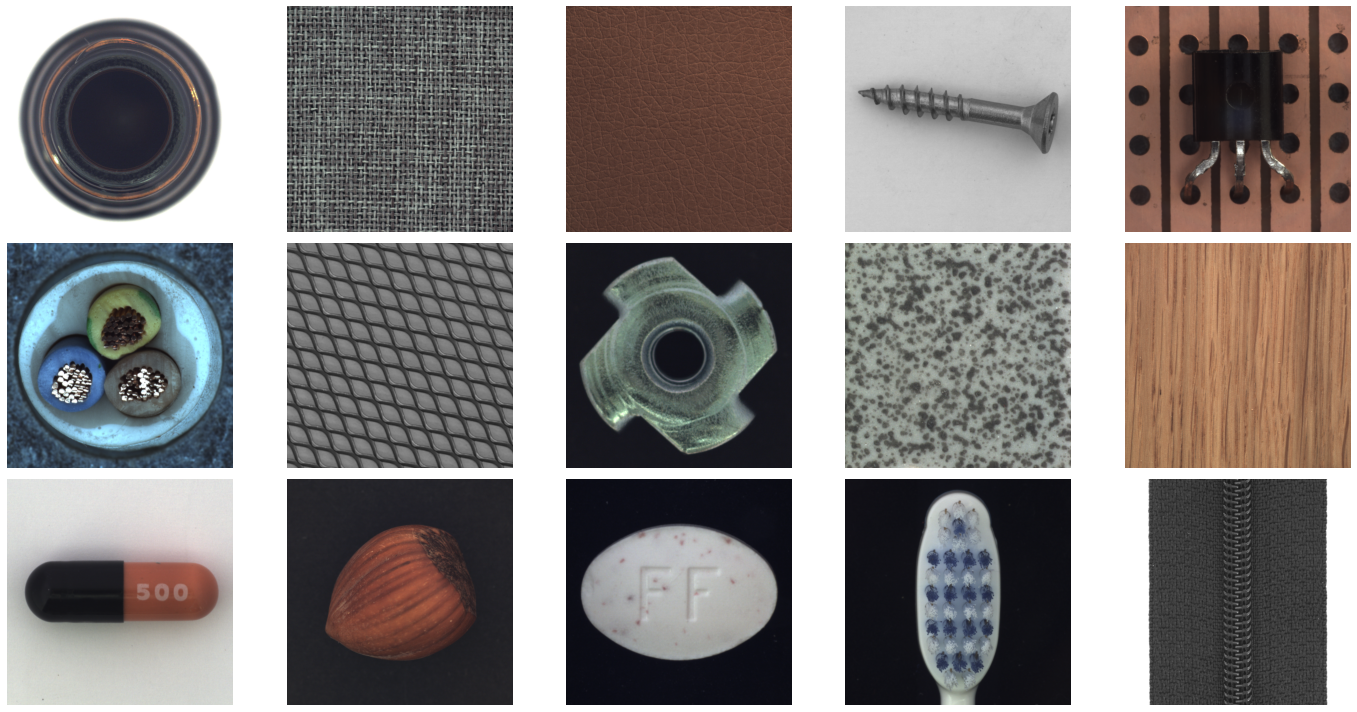

In [52]:
import cv2 

fig,axes = plt.subplots(3,5,figsize=(20,10))
for i, cn in enumerate(class_names):
    temp = df[df['class_name']==cn]
    img_dir = temp[0].sample(1).values[0]

    img = cv2.imread(img_dir)
    
    axes[i%3,i//3].imshow(img[:,:,::-1])
    axes[i%3,i//3].axis(False)
plt.tight_layout()    
    

In [45]:
i//3

0

In [44]:
i//3

0

In [2]:
from ContinualLearning import InstanceIncremental
scenario = InstanceIncremental(
    trainset        = trainset,
    scheduler       = cfg.SCHEDULER,
    optimizer       = cfg.OPTIMIZER,
    nb_tasks        = cfg.CONTINUAL.nb_tasks,
    init_data_ratio = cfg.CONTINUAL.init_data_ratio,
    batch_size      = cfg.DATASET.batch_size,
    epochs          = cfg.TRAIN.epochs
)

In [3]:
scenario.n_epoch_task

array([200.  , 112.5 , 112.5 , 112.5 , 112.5 , 112.5 , 112.5 , 112.5 ,
       106.25, 106.25])

In [4]:
import math 
self = scenario 
batch_size = 32 
epochs = 200 

n_data_task = np.array([len(t) for t in self.trainsets])
n_data_task_p = n_data_task/np.sum(n_data_task)

total_step = (math.ceil(len(self.trainset)/batch_size)) * epochs 
n_step_task = n_data_task_p * total_step 
n_epoch_task = n_step_task  / np.ceil(n_data_task/batch_size)

In [14]:
n_epoch_task

array([200.        , 166.66666667, 166.66666667])